## Preparar entorno y credenciales

In [1]:
# Instalar XGBoost (por si no lo tienes)
!pip install xgboost --quiet

### Colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Configurar conexión con el servidor MLflow

In [3]:
# Instalar mlflow y pyngrok (si no están ya)
!pip install mlflow pyngrok --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 700.2/700.2 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.0/119.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.9/194.9 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62

In [4]:
# Leer token desde archivo secreto
with open('/content/drive/MyDrive/secrets/ngrok_token.txt', 'r') as f:
    ngrok_token = f.read().strip()

# Configurar ngrok sin exponer el token
from pyngrok import conf
conf.get_default().auth_token = ngrok_token

In [5]:
# Configurar el directorio de MLflow para que se guarde en Drive
import os
os.environ['MLFLOW_TRACKING_URI'] = "/content/drive/MyDrive/MIAA/Clases/Herramientas IA/Prácticas/MIAA_taller02/model/MIAA/mlflow_tracking"

In [6]:
# 1. Matar túneles anteriores
from pyngrok import ngrok
ngrok.kill()

# 2. Importar librerías necesarias
import subprocess
import mlflow

# 3. Establecer tracking URI para los registros desde código (útil para registrar experimentos)
mlflow.set_tracking_uri("file:///content/drive/MyDrive/MIAA/Clases/Herramientas IA/Prácticas/MIAA_taller02/model/mlflow_tracking")

# 4. Lanzar MLflow UI con la misma URI (para que use la misma carpeta de seguimiento)
mlflow_process = subprocess.Popen([
    "mlflow", "ui",
    "--port", "9090",
    "--backend-store-uri", "file:///content/drive/MyDrive/MIAA/Clases/Herramientas IA/Prácticas/MIAA_taller02/model/mlflow_tracking"
])

# 5. Exponer UI con ngrok
mlflow_tunnel = ngrok.connect(9090, "http")
print("🌐 MLflow UI disponible en:", mlflow_tunnel.public_url)

🌐 MLflow UI disponible en: https://aabe-35-247-105-223.ngrok-free.app


## Modelado

Preparar el df

In [ ]:
import pandas as pd
import numpy as np

df= pd.read_csv("/content/drive/MyDrive/MIAA/Clases/Herramientas IA/Prácticas/MIAA_taller02/data/df_balanceH_historico.csv")
# Convertimos la fecha y ordenamos
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

# Extraemos año y mes
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Revisión básica
print(df.head())
print(df.columns)

        date  PET_mm_day  year  month  PET_mm_month  precip_mm     temp_c  \
0 1981-01-01    0.146402  1981      1      4.538457  17.320967  13.820871   
1 1981-02-01    0.175214  1981      2      4.906004  21.017205  14.046861   
2 1981-03-01    0.120592  1981      3      3.738337  19.203109  14.441554   
3 1981-04-01    0.150655  1981      4      4.519645  17.264962  14.619948   
4 1981-05-01    0.152015  1981      5      4.712460  17.055039  14.424726   

     wind_u    wind_v  solar_rad  balance_mm  
0  0.085281 -0.137070  12.716649   12.782510  
1 -0.126304  0.013116  12.303850   16.111201  
2  0.124552 -0.137545  12.726321   15.464772  
3  0.059594 -0.078826  13.345170   12.745317  
4 -0.047208 -0.076885  12.216821   12.342579  
Index(['date', 'PET_mm_day', 'year', 'month', 'PET_mm_month', 'precip_mm',
       'temp_c', 'wind_u', 'wind_v', 'solar_rad', 'balance_mm'],
      dtype='object')


**División en entrenamiento y prueba**
Vamos a usar:

- Entrenamiento: hasta 2020 inclusive
- Prueba: 2021–2023 (para validar capacidad de generalización)
- También normalizaremos las variables para usar en XGBoost y LSTM.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Seleccionar características predictoras y variable objetivo
features = ['precip_mm','temp_c', 'wind_u', 'wind_v', 'solar_rad']
target = 'balance_mm'

# Normalizadores
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Filtrar datos por fecha
df_train = df[df['year'] <= 2020]
df_test = df[df['year'] > 2020]

# Aplicar escalado
X_train = scaler_X.fit_transform(df_train[features])
y_train = scaler_y.fit_transform(df_train[[target]])

X_test = scaler_X.transform(df_test[features])
y_test = scaler_y.transform(df_test[[target]])

**Modelo XGBoost**

In [ ]:
import mlflow
import mlflow.sklearn
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Asegurar URI y experimento activo
mlflow.set_tracking_uri(mlflow_tunnel.public_url)
mlflow.set_experiment("balance_hidrico_modelo_xgboost")

# Lista de configuraciones de hiperparámetros
param_grid = [
    {"n_estimators": 100, "learning_rate": 0.1},
    {"n_estimators": 200, "learning_rate": 0.1},
    {"n_estimators": 100, "learning_rate": 0.05},
    {"n_estimators": 200, "learning_rate": 0.05}
]

# Entrenamiento y registro por cada configuración
for i, params in enumerate(param_grid):
    with mlflow.start_run(run_name=f"xgboost_v{i+1}"):
        model = XGBRegressor(n_estimators=params["n_estimators"],
                             learning_rate=params["learning_rate"],
                             random_state=42)
        model.fit(X_train, y_train.ravel())

        # Predicción y desescalado
        y_pred_scaled = model.predict(X_test)
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
        y_test_inv = scaler_y.inverse_transform(y_test)

        # Métricas
        rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred))
        mae = mean_absolute_error(y_test_inv, y_pred)
        r2 = r2_score(y_test_inv, y_pred)

        # Registro en MLflow
        mlflow.log_param("n_estimators", params["n_estimators"])
        mlflow.log_param("learning_rate", params["learning_rate"])
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("r2", r2)

        mlflow.sklearn.log_model(model, "xgboost_model")

        print(f"✅ Versión {i+1} registrada → n_estimators={params['n_estimators']}, learning_rate={params['learning_rate']}")

2025/05/19 02:34:20 INFO mlflow.tracking.fluent: Experiment with name 'balance_hidrico_modelo_xgboost' does not exist. Creating a new experiment.
2025/05/19 02:34:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Versión 1 registrada → n_estimators=100, learning_rate=0.1
🏃 View run xgboost_v1 at: https://11b6-34-19-109-156.ngrok-free.app/#/experiments/540120399623805156/runs/c987eb48b6154c998a21426771973334
🧪 View experiment at: https://11b6-34-19-109-156.ngrok-free.app/#/experiments/540120399623805156


2025/05/19 02:34:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Versión 2 registrada → n_estimators=200, learning_rate=0.1
🏃 View run xgboost_v2 at: https://11b6-34-19-109-156.ngrok-free.app/#/experiments/540120399623805156/runs/e896f01cee424df3a56c29c1eae7fe48
🧪 View experiment at: https://11b6-34-19-109-156.ngrok-free.app/#/experiments/540120399623805156


2025/05/19 02:34:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Versión 3 registrada → n_estimators=100, learning_rate=0.05
🏃 View run xgboost_v3 at: https://11b6-34-19-109-156.ngrok-free.app/#/experiments/540120399623805156/runs/93a57b8dbc4b441690b17b15a80a2148
🧪 View experiment at: https://11b6-34-19-109-156.ngrok-free.app/#/experiments/540120399623805156


2025/05/19 02:35:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Versión 4 registrada → n_estimators=200, learning_rate=0.05
🏃 View run xgboost_v4 at: https://11b6-34-19-109-156.ngrok-free.app/#/experiments/540120399623805156/runs/5b902b9ffd4a4dd4a1514d0e00d7ccf1
🧪 View experiment at: https://11b6-34-19-109-156.ngrok-free.app/#/experiments/540120399623805156


**Registrar modelo LSTM multistep en MLflow**

In [ ]:
import mlflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Asegurar tracking al experimento (mismo que XGBoost o uno nuevo si prefieres)
mlflow.set_tracking_uri(mlflow_tunnel.public_url)
mlflow.set_experiment("balance_hidrico_modelo_lstm")

# Reutilizamos los datos ya escalados
window_size = 3

# Función para crear secuencias
def create_sequences(X, y, window=3):
    Xs, ys = [], []
    for i in range(len(X) - window):
        Xs.append(X[i:i + window])
        ys.append(y[i + window])
    return np.array(Xs), np.array(ys)

# Secuencias para LSTM
X_train_seq, y_train_seq = create_sequences(X_train, y_train, window=window_size)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, window=window_size)

# Iniciar run en MLflow
with mlflow.start_run(run_name="lstm_multistep_v1"):
    # Modelo LSTM
    model = Sequential([
        LSTM(64, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    # Callback de early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Entrenamiento
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_split=0.2,
        epochs=200,
        batch_size=16,
        callbacks=[early_stop],
        verbose=0
    )

    # Predicción y desescalado
    y_pred_lstm_scaled = model.predict(X_test_seq)
    y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm_scaled)
    y_test_inv = scaler_y.inverse_transform(y_test_seq)

    # Evaluación
    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_lstm))
    mae = mean_absolute_error(y_test_inv, y_pred_lstm)
    r2 = r2_score(y_test_inv, y_pred_lstm)

    # Registro en MLflow
    mlflow.log_param("window_size", window_size)
    mlflow.log_param("lstm_units", 64)
    mlflow.log_param("batch_size", 16)
    mlflow.log_param("epochs", len(history.history['loss']))

    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)

    # Guardar modelo
    mlflow.keras.log_model(model, "lstm_model")

print(f"✅ Modelo LSTM registrado en MLflow con window={window_size}")

2025/05/19 02:35:07 INFO mlflow.tracking.fluent: Experiment with name 'balance_hidrico_modelo_lstm' does not exist. Creating a new experiment.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step


2025/05/19 02:35:28 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/05/19 02:35:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run lstm_multistep_v1 at: https://11b6-34-19-109-156.ngrok-free.app/#/experiments/701267198592949748/runs/f5b02d0fdf5140dcb751e18883b7045e
🧪 View experiment at: https://11b6-34-19-109-156.ngrok-free.app/#/experiments/701267198592949748
✅ Modelo LSTM registrado en MLflow con window=3


### **Visualización**
Generaremos un gráfico de líneas comparando:

- 🔵 Valores reales del balance_mm (2021–2023)

- 🔴 Predicciones de XGBoost

- 🟣 Predicciones de LSTM

In [ ]:
import mlflow
import mlflow.sklearn
import mlflow.keras

# Asegura conexión al mismo tracking server
mlflow.set_tracking_uri(mlflow_tunnel.public_url)

# 🔴 Cargar mejor modelo XGBoost desde su ruta en MLflow
xgb_model_uri = "runs:/c987eb48b6154c998a21426771973334/xgboost_model"
xgb_model_best = mlflow.sklearn.load_model(xgb_model_uri)

# 🟣 Cargar mejor modelo LSTM desde su ruta en MLflow
lstm_model_uri = "runs:/f5b02d0fdf5140dcb751e18883b7045e/lstm_model"
lstm_model_best = mlflow.keras.load_model(lstm_model_uri)

**Guardar modelo como pkl**

In [ ]:
import joblib
import os

# Crear la carpeta destino si no existe
output_dir = "/content/drive/MyDrive/MIAA/Clases/Herramientas IA/Prácticas/MIAA_taller02/model"
os.makedirs(output_dir, exist_ok=True)

# Guardar como .pkl
pkl_path = os.path.join(output_dir, "modelo_xgboost_v1.pkl")
joblib.dump(xgb_model_best, pkl_path)

print(f"✅ Modelo guardado exitosamente en:\n{pkl_path}")

✅ Modelo guardado exitosamente en:
/content/drive/MyDrive/MIAA/Clases/Herramientas IA/Prácticas/MIAA_taller02/model/modelo_xgboost_v1.pkl


In [ ]:
# Ruta de destino
output_dir = "/content/drive/MyDrive/MIAA/Clases/Herramientas IA/Prácticas/MIAA_taller02/model"
os.makedirs(output_dir, exist_ok=True)

# Guardar escaladores
joblib.dump(scaler_X, f"{output_dir}/scaler_X.pkl")
joblib.dump(scaler_y, f"{output_dir}/scaler_y.pkl")

print("✅ Escaladores guardados correctamente en:")
print(output_dir)

✅ Escaladores guardados correctamente en:
/content/drive/MyDrive/MIAA/Clases/Herramientas IA/Prácticas/MIAA_taller02/modelo


In [ ]:
# -------------------------
# 1. Cargar datos de evaluación
# -------------------------
df_eval = df.copy()
df_eval = df_eval[(df_eval['date'] >= '2021-01-01') & (df_eval['date'] <= '2023-12-31')].reset_index(drop=True)

X_eval = scaler_X.transform(df_eval[features])
y_eval = scaler_y.transform(df_eval[[target]])

# -------------------------
# 2. Predicción con XGBoost
# -------------------------
y_pred_xgb_scaled = xgb_model_best.predict(X_eval)
y_pred_xgb = scaler_y.inverse_transform(y_pred_xgb_scaled.reshape(-1, 1)).flatten()

# -------------------------
# 3. Predicción con LSTM
# -------------------------

# Crear secuencias
def create_sequences(X, y, window=3):
    Xs, ys = [], []
    for i in range(len(X) - window):
        Xs.append(X[i:i + window])
        ys.append(y[i + window])
    return np.array(Xs), np.array(ys)

window_size = 3
X_eval_seq, y_eval_seq = create_sequences(X_eval, y_eval, window=window_size)

# Predecir
y_pred_lstm_scaled = lstm_model_best.predict(X_eval_seq)
y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm_scaled)

# Fechas alineadas para LSTM
fechas_lstm = df_eval.iloc[window_size:]['date'].reset_index(drop=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


<ipython-input-13-e10dd7446f85>:16: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-13-e10dd7446f85>:16: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-13-e10dd7446f85>:16: UserWarning: Glyph 128995 (\N{LARGE PURPLE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128995 (\N{LARGE PURPLE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figu

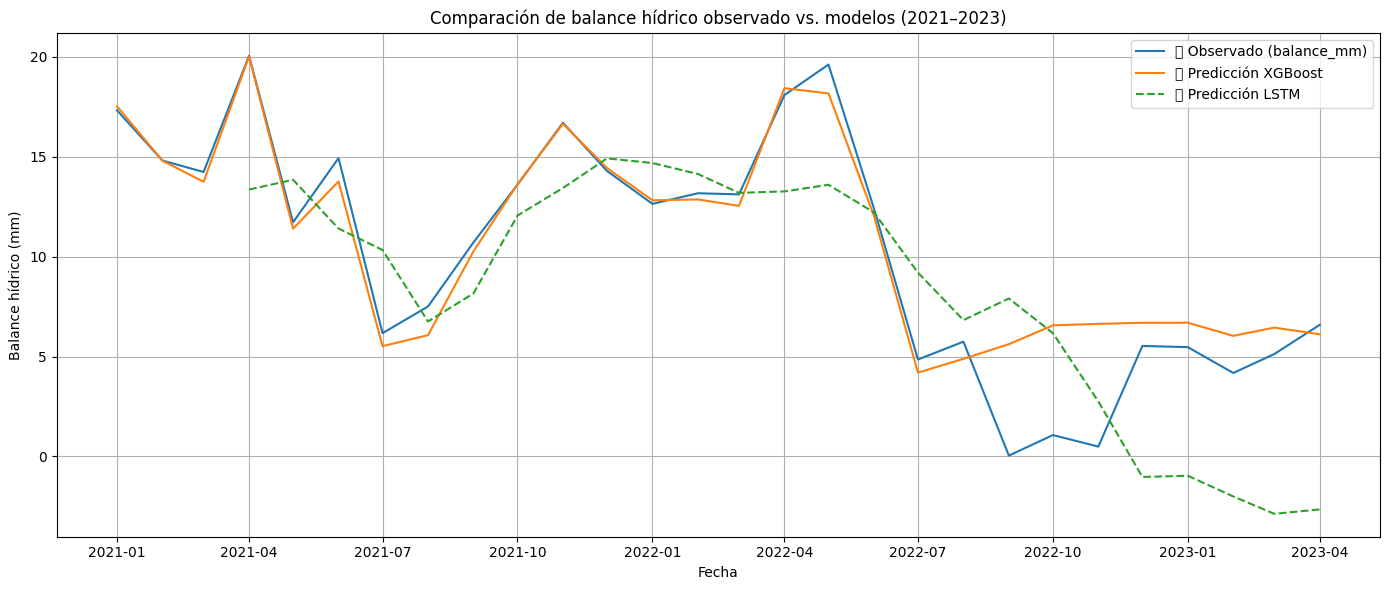

In [ ]:
# -------------------------
# Visualización
# -------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(df_eval['date'], df_eval['balance_mm'], label='🔵 Observado (balance_mm)')
plt.plot(df_eval['date'], y_pred_xgb, label='🔴 Predicción XGBoost')
plt.plot(fechas_lstm, y_pred_lstm.flatten(), '--', label='🟣 Predicción LSTM')

plt.title("Comparación de balance hídrico observado vs. modelos (2021–2023)")
plt.xlabel("Fecha")
plt.ylabel("Balance hídrico (mm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### **Proyección del balance hídrico 2024–2050**

In [ ]:
df_cmip6 = pd.read_csv("/content/drive/MyDrive/MIAA/Clases/Herramientas IA/Prácticas/MIAA_taller02/data/df_cmip6.csv")
# Asegurar que 'date' está en formato datetime
df_cmip6['date'] = pd.to_datetime(df_cmip6['date'])
df_cmip6.head()

,date,precip_mm,year,month,temp_c,wind_u,wind_v,solar_rad
0,2015-01-16 12:00:00,9.386863,2015,1,18.273834,-9.422890,0.641277,523.460668
1,2015-02-15 00:00:00,15.993875,2015,2,18.285797,-7.968413,0.566743,469.260540
2,2015-03-16 12:00:00,26.977810,2015,3,18.154694,-4.723524,0.570539,406.331694
3,2015-04-16 00:00:00,28.607992,2015,4,18.255768,-2.849622,0.169271,390.057930
4,2015-05-16 12:00:00,23.624590,2015,5,17.569214,-1.718866,0.157390,414.653055


### **Predicciones con XGBOOST**

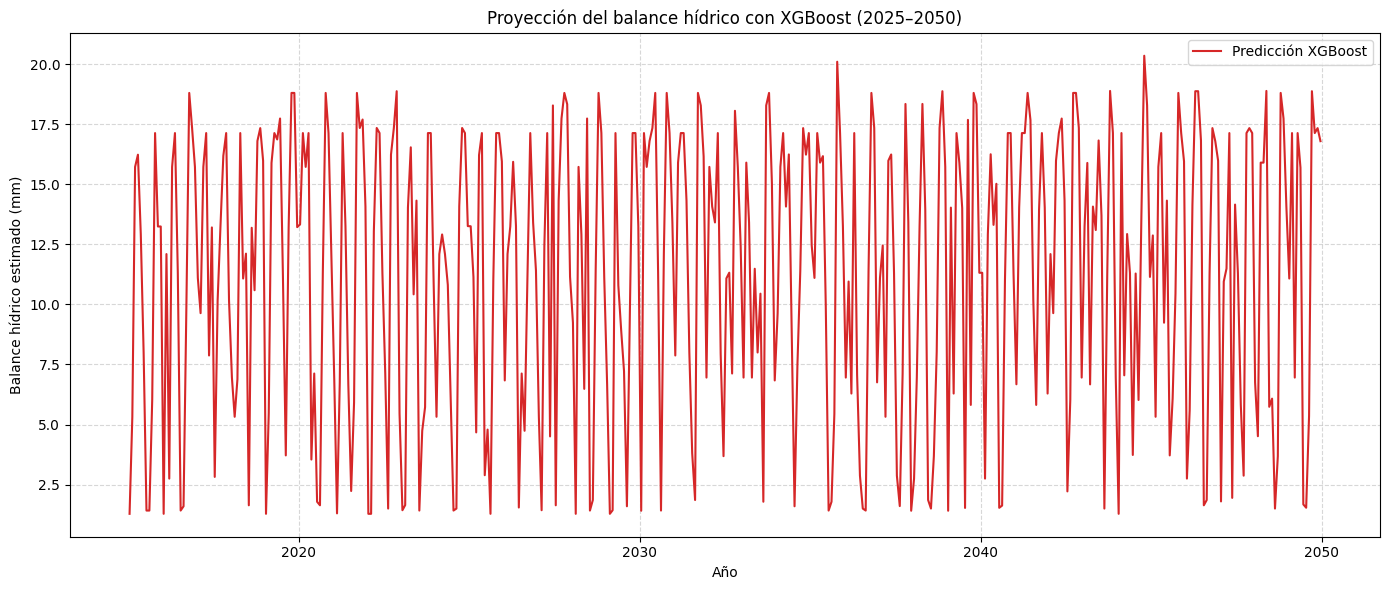

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Paso 1: Asegurar formato datetime en fechas
df_cmip6['date'] = pd.to_datetime(df_cmip6['date'])

# Paso 2: Preparar entradas
df_input = df_cmip6.copy()
X_new = scaler_X.transform(df_input[['precip_mm', 'temp_c', 'wind_u', 'wind_v', 'solar_rad']])

# Paso 3: Predicción con modelo XGBoost cargado desde MLflow
y_pred_xgb_new_scaled = xgb_model_best.predict(X_new)
y_pred_xgb_new = scaler_y.inverse_transform(y_pred_xgb_new_scaled.reshape(-1, 1))

# Paso 4: Agregar resultados al DataFrame
df_input['balance_pred_xgb'] = y_pred_xgb_new

# Paso 5: Visualizar predicciones
plt.figure(figsize=(14,6))
plt.plot(df_input['date'], df_input['balance_pred_xgb'], label='Predicción XGBoost', color='tab:red')

# Eje X: mostrar solo años cada 10
plt.gca().xaxis.set_major_locator(mdates.YearLocator(10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xlabel("Año")
plt.ylabel("Balance hídrico estimado (mm)")
plt.title("Proyección del balance hídrico con XGBoost (2025–2050)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()